<a href="https://colab.research.google.com/github/santhapriyan17/CAS03-CS03/blob/main/CASTILO_Hackathon_team_Imposters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 17.6 MB/s eta 0:00:00
Generating training data...
Preprocessing data and training models...
Evaluating models...

Random Forest Accuracy: 1.0000

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1406
           1       1.00      1.00      1.00       594

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Isolation Forest Accuracy: 0.8050

Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1406
           1       1.00      0.34      0.51       594

    accuracy                           0.81      2000
   macro avg       0.89      0.67      0.69      2000
weighted avg       0.85      0.81      0.77      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

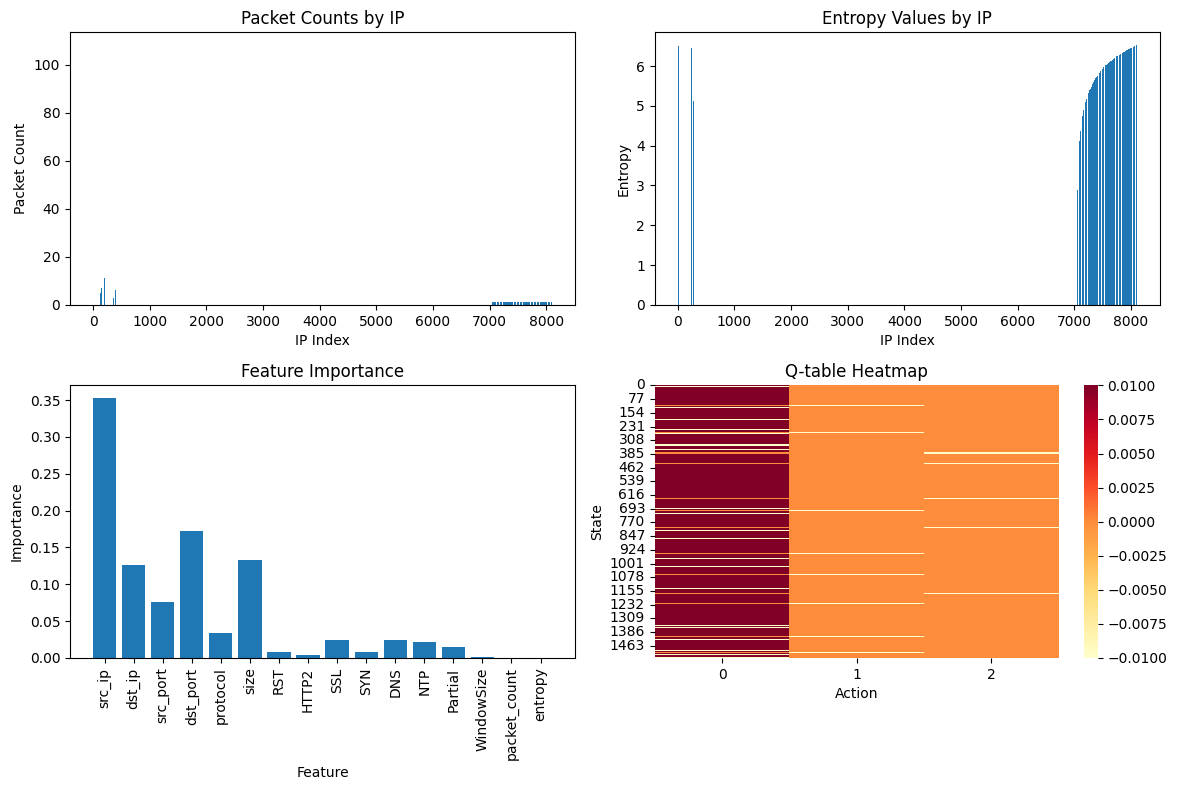

In [ ]:
# enhanced model
!pip install scapy seaborn tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import ipaddress
import time
from collections import defaultdict
from scipy.stats import entropy
import random

# Constants
SIMULATION_DURATION = 200  # seconds
PACKET_INTERVAL = 0.001  # seconds
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.99
EPSILON = 0.1
NUM_BOTNET_IPS = 50

class NetworkPacket:
    def __init__(self, src_ip, dst_ip, src_port, dst_port, protocol, size, flags=None):
        self.src_ip = src_ip
        self.dst_ip = dst_ip
        self.src_port = src_port
        self.dst_port = dst_port
        self.protocol = protocol
        self.size = size
        self.flags = flags or {}
        self.timestamp = time.time()

class DDoSDetector:
    def __init__(self):
        self.rf_model = None
        self.if_model = None
        self.autoencoder = None
        self.scaler = StandardScaler()
        self.feature_importance = None
        self.detection_threshold = 0.5
        self.recent_predictions = []
        self.ip_packet_counts = defaultdict(int)
        self.ip_entropy_values = defaultdict(float)
        self.q_table = defaultdict(lambda: np.zeros(3))  # 3 actions: 0 (normal), 1 (potential DDoS), 2 (confirmed DDoS)
        self.botnet_ips = [f"10.0.0.{i}" for i in range(1, NUM_BOTNET_IPS + 1)]
        self.attack_types = [
            self.http2_rapid_reset,
            self.https_flood,
            self.syn_flood,
            self.udp_flood,
            self.dns_amplification,
            self.ntp_amplification,
            self.slowloris,
            self.tcp_sockstress
        ]
        self.mitigation_strategies = {
            "rate_limiting": self.rate_limiting,
            "ip_blocking": self.ip_blocking,
            "traffic_rerouting": self.traffic_rerouting,
            "challenge_response": self.challenge_response
        }
        self.packet_history = []
        self.anomaly_scores = []

    def generate_normal_traffic(self):
        src_ip = f"{np.random.randint(1, 256)}.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}"
        dst_ip = f"{np.random.randint(1, 256)}.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}"
        src_port = np.random.randint(1024, 65536)
        dst_port = np.random.randint(1, 1024)
        protocol = np.random.choice(['TCP', 'UDP', 'ICMP'])
        size = np.random.randint(64, 1500)
        return NetworkPacket(src_ip, dst_ip, src_port, dst_port, protocol, size)

    def http2_rapid_reset(self):
        src_ip = random.choice(self.botnet_ips)
        dst_ip = "192.168.1.1"  # Target server
        src_port = np.random.randint(1024, 65536)
        dst_port = 443
        protocol = 'TCP'
        size = 100  # Small packets
        flags = {'RST': 1, 'HTTP2': True}
        return NetworkPacket(src_ip, dst_ip, src_port, dst_port, protocol, size, flags)

    def https_flood(self):
        src_ip = random.choice(self.botnet_ips)
        dst_ip = "192.168.1.1"  # Target server
        src_port = np.random.randint(1024, 65536)
        dst_port = 443
        protocol = 'TCP'
        size = np.random.randint(1000, 2000)  # Larger packets for HTTPS requests
        flags = {'SSL': True}
        return NetworkPacket(src_ip, dst_ip, src_port, dst_port, protocol, size, flags)

    def syn_flood(self):
        src_ip = random.choice(self.botnet_ips)
        dst_ip = "192.168.1.1"  # Target server
        src_port = np.random.randint(1024, 65536)
        dst_port = 80
        protocol = 'TCP'
        size = 60  # SYN packets are typically small
        flags = {'SYN': 1}
        return NetworkPacket(src_ip, dst_ip, src_port, dst_port, protocol, size, flags)

    def udp_flood(self):
        src_ip = random.choice(self.botnet_ips)
        dst_ip = "192.168.1.1"  # Target server
        src_port = np.random.randint(1024, 65536)
        dst_port = np.random.randint(1, 65536)
        protocol = 'UDP'
        size = np.random.randint(64, 1500)
        return NetworkPacket(src_ip, dst_ip, src_port, dst_port, protocol, size)

    def dns_amplification(self):
        src_ip = "192.168.1.1"  # Spoofed source IP (target)
        dst_ip = f"8.8.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}"  # DNS server
        src_port = 53
        dst_port = np.random.randint(1024, 65536)
        protocol = 'UDP'
        size = np.random.randint(512, 4096)  # DNS responses can be large
        flags = {'DNS': True}
        return NetworkPacket(src_ip, dst_ip, src_port, dst_port, protocol, size, flags)

    def ntp_amplification(self):
        src_ip = "192.168.1.1"  # Spoofed source IP (target)
        dst_ip = f"123.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}.{np.random.randint(0, 256)}"  # NTP server
        src_port = 123
        dst_port = np.random.randint(1024, 65536)
        protocol = 'UDP'
        size = np.random.randint(1000, 5000)  # NTP responses can be very large
        flags = {'NTP': True}
        return NetworkPacket(src_ip, dst_ip, src_port, dst_port, protocol, size, flags)

    def slowloris(self):
        src_ip = random.choice(self.botnet_ips)
        dst_ip = "192.168.1.1"  # Target server
        src_port = np.random.randint(1024, 65536)
        dst_port = 80
        protocol = 'TCP'
        size = 200  # Small packets
        flags = {'ACK': 1, 'Partial': True}
        return NetworkPacket(src_ip, dst_ip, src_port, dst_port, protocol, size, flags)

    def tcp_sockstress(self):
        src_ip = random.choice(self.botnet_ips)
        dst_ip = "192.168.1.1"  # Target server
        src_port = np.random.randint(1024, 65536)
        dst_port = 80
        protocol = 'TCP'
        size = 60  # Small packets
        flags = {'ACK': 1, 'WindowSize': 0}
        return NetworkPacket(src_ip, dst_ip, src_port, dst_port, protocol, size, flags)

    def generate_ddos_traffic(self):
        attack_func = random.choice(self.attack_types)
        return attack_func()

    def generate_mixed_traffic(self, ddos_ratio=0.3):
        if np.random.random() < ddos_ratio:
            return self.generate_ddos_traffic(), 1  # 1 indicates DDoS traffic
        else:
            return self.generate_normal_traffic(), 0  # 0 indicates normal traffic

    def extract_features(self, packet: NetworkPacket):
        features = [
            int(ipaddress.IPv4Address(packet.src_ip)),
            int(ipaddress.IPv4Address(packet.dst_ip)),
            packet.src_port,
            packet.dst_port,
            {'TCP': 0, 'UDP': 1, 'ICMP': 2}.get(packet.protocol, 3),
            packet.size,
            int(packet.flags.get('RST', 0)),
            int(packet.flags.get('HTTP2', 0)),
            int(packet.flags.get('SSL', 0)),
            int(packet.flags.get('SYN', 0)),
            int(packet.flags.get('DNS', 0)),
            int(packet.flags.get('NTP', 0)),
            int(packet.flags.get('Partial', 0)),
            int(packet.flags.get('WindowSize', 1)),
            self.ip_packet_counts[packet.src_ip],
            self.ip_entropy_values[packet.src_ip]
        ]
        return features

    def preprocess_data(self, data):
        X = np.array([self.extract_features(packet) for packet, _ in data])
        y = np.array([label for _, label in data])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    def build_autoencoder(self, input_dim):
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(64, activation='relu')(input_layer)
        encoded = Dense(32, activation='relu')(encoded)
        encoded = Dense(16, activation='relu')(encoded)
        decoded = Dense(32, activation='relu')(encoded)
        decoded = Dense(64, activation='relu')(decoded)
        decoded = Dense(input_dim, activation='linear')(decoded)

        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        return autoencoder

    def train_models(self, X_train, y_train):
        # Random Forest
        self.rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.rf_model.fit(X_train, y_train)
        self.feature_importance = self.rf_model.feature_importances_

        # Isolation Forest
        self.if_model = IsolationForest(contamination=0.1, random_state=42)
        self.if_model.fit(X_train)

        # Autoencoder
        self.autoencoder = self.build_autoencoder(X_train.shape[1])
        self.autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

    def evaluate_models(self, X_test, y_test):
        # Random Forest evaluation
        rf_pred = self.rf_model.predict(X_test)
        rf_accuracy = accuracy_score(y_test, rf_pred)
        print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")
        print("\nRandom Forest Classification Report:")
        print(classification_report(y_test, rf_pred))

        # Isolation Forest evaluation
        if_pred = self.if_model.predict(X_test)
        if_pred = [1 if x == -1 else 0 for x in if_pred]  # Convert to binary (1 for anomaly, 0 for normal)
        if_accuracy = accuracy_score(y_test, if_pred)
        print(f"\nIsolation Forest Accuracy: {if_accuracy:.4f}")
        print("\nIsolation Forest Classification Report:")
        print(classification_report(y_test, if_pred))

        # Autoencoder evaluation
        reconstructed = self.autoencoder.predict(X_test)
        mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)
        threshold = np.percentile(mse, 95)  # 95th percentile as threshold
        ae_pred = [1 if error > threshold else 0 for error in mse]
        ae_accuracy = accuracy_score(y_test, ae_pred)
        print(f"\nAutoencoder Accuracy: {ae_accuracy:.4f}")
        print("\nAutoencoder Classification Report:")
        print(classification_report(y_test, ae_pred))

        return (rf_accuracy + if_accuracy + ae_accuracy) / 3  # Average accuracy

    def adaptive_threshold(self):
        if len(self.recent_predictions) > 100:
            self.detection_threshold = np.mean(self.recent_predictions) + 2 * np.std(self.recent_predictions)

    def calculate_entropy(self, ip):
        total_packets = sum(self.ip_packet_counts.values())
        probabilities = [count / total_packets for count in self.ip_packet_counts.values()]
        return entropy(probabilities)

    def get_state(self, packet: NetworkPacket):
        src_ip_int = int(ipaddress.IPv4Address(packet.src_ip))
        packet_count = self.ip_packet_counts[packet.src_ip]
        entropy = self.ip_entropy_values[packet.src_ip]
        return (src_ip_int, packet_count, entropy)

    def get_action(self, state):
        if np.random.random() < EPSILON:
            return np.random.choice([0, 1, 2])
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        current_q = self.q_table[state][action]
        next_max_q = np.max(self.q_table[next_state])
        new_q = current_q + LEARNING_RATE * (reward + DISCOUNT_FACTOR * next_max_q - current_q)
        self.q_table[state][action] = new_q

    def detect_ddos(self, packet: NetworkPacket):
        features = self.extract_features(packet)
        features_scaled = self.scaler.transform([features])

        # Random Forest prediction
        rf_prob = self.rf_model.predict_proba(features_scaled)[0][1]

        # Isolation Forest prediction
        if_score = self.if_model.decision_function(features_scaled)[0]
        if_prob = 1 - (if_score + 0.5)  # Convert to probability-like score

        # Autoencoder prediction
        reconstructed = self.autoencoder.predict(features_scaled)
        mse = np.mean(np.power(features_scaled - reconstructed, 2))
        ae_prob = mse / self.detection_threshold

        # Combine predictions
        combined_prob = (rf_prob + if_prob + ae_prob) / 3

        self.recent_predictions.append(combined_prob)
        self.adaptive_threshold()

        # Update IP-based statistics
        self.ip_packet_counts[packet.src_ip] += 1
        self.ip_entropy_values[packet.src_ip] = self.calculate_entropy(packet.src_ip)

        # Get current state and action
        state = self.get_state(packet)
        action = self.get_action(state)

        # Determine if it's a DDoS attack
        is_ddos = combined_prob > self.detection_threshold

        # Calculate reward
        reward = 1 if (is_ddos and action > 0) or (not is_ddos and action == 0) else -1

        # Update Q-table
        next_state = self.get_state(packet)  # In a real scenario, this would be the next packet's state
        self.update_q_table(state, action, reward, next_state)

        return is_ddos, action

    def rate_limiting(self, packet: NetworkPacket):
        # Implement rate limiting logic
        pass

    def ip_blocking(self, packet: NetworkPacket):
        # Implement IP blocking logic
        pass

    def traffic_rerouting(self, packet: NetworkPacket):
        # Implement traffic rerouting logic
        pass

    def challenge_response(self, packet: NetworkPacket):
        # Implement challenge-response mechanism
        pass

    def mitigate_ddos(self, packet: NetworkPacket, action):
        if action == 1:  # Potential DDoS
            self.rate_limiting(packet)
        elif action == 2:  # Confirmed DDoS
            self.ip_blocking(packet)
            self.traffic_rerouting(packet)
            self.challenge_response(packet)

    def run_simulation(self):
        start_time = time.time()
        packet_count = 0
        ddos_detected_count = 0

        while time.time() - start_time < SIMULATION_DURATION:
            packet, _ = self.generate_mixed_traffic()
            is_ddos, action = self.detect_ddos(packet)

            if is_ddos:
                ddos_detected_count += 1
                self.mitigate_ddos(packet, action)

            packet_count += 1
            time.sleep(PACKET_INTERVAL)

        print(f"Simulation complete. Processed {packet_count} packets.")
        print(f"Detected {ddos_detected_count} potential DDoS attacks.")
        print(f"False positive rate: {ddos_detected_count / packet_count:.2%}")

    def visualize_results(self):
        plt.figure(figsize=(12, 8))

        # Plot packet counts
        plt.subplot(2, 2, 1)
        plt.bar(range(len(self.ip_packet_counts)), self.ip_packet_counts.values())
        plt.title('Packet Counts by IP')
        plt.xlabel('IP Index')
        plt.ylabel('Packet Count')

        # Plot entropy values
        plt.subplot(2, 2, 2)
        plt.bar(range(len(self.ip_entropy_values)), self.ip_entropy_values.values())
        plt.title('Entropy Values by IP')
        plt.xlabel('IP Index')
        plt.ylabel('Entropy')

        # Plot feature importance
        plt.subplot(2, 2, 3)
        feature_names = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'size', 'RST', 'HTTP2', 'SSL', 'SYN', 'DNS', 'NTP', 'Partial', 'WindowSize', 'packet_count', 'entropy']
        plt.bar(range(len(self.feature_importance)), self.feature_importance)
        plt.title('Feature Importance')
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.xticks(range(len(feature_names)), feature_names, rotation=90)

        # Plot Q-table heatmap
        plt.subplot(2, 2, 4)
        q_values = np.array(list(self.q_table.values()))
        sns.heatmap(q_values, cmap='YlOrRd')
        plt.title('Q-table Heatmap')
        plt.xlabel('Action')
        plt.ylabel('State')

        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    detector = DDoSDetector()

    # Generate training data
    print("Generating training data...")
    training_data = [detector.generate_mixed_traffic() for _ in range(10000)]

    # Preprocess and train models
    print("Preprocessing data and training models...")
    X_train, X_test, y_train, y_test = detector.preprocess_data(training_data)
    detector.train_models(X_train, y_train)

    # Evaluate models
    print("Evaluating models...")
    avg_accuracy = detector.evaluate_models(X_test, y_test)
    print(f"Average model accuracy: {avg_accuracy:.4f}")

    # Run simulation
    print("Running DDoS detection simulation...")
    detector.run_simulation()

    # Visualize results
    detector.visualize_results()